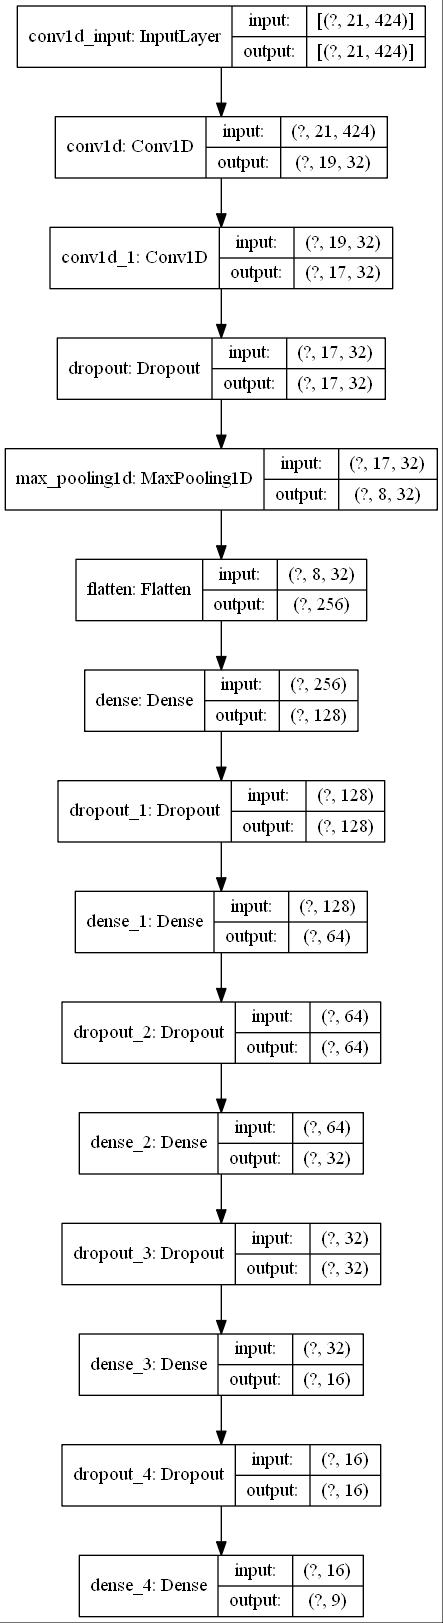

In [1]:
#%%

import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers.merge import concatenate
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.utils.vis_utils import plot_model
from typing import List

#%% md

#### define the tickers and indicators used

#%%

# exchange tickers
tickers = list([
    "SPY",  # S&P 500 Index Fund
    "IWV",  # Russell 3000 Index Fund
    "QQQ",  # Technology Sector Fund
    "IYF",  # Financials Sector Fund
    "XLP",  # Consumer Staples Sector Fund
    "XLU",  # Utilities Sector Funds
    "XLV",  # Health Care Sector Funds
    "IGE",  # NA Natural Resources ETF
    "XLE"  # Energy Sector Fund
])

# alias and FRED indicator
indicators = dict({
    "3M_TBILL": "DTB3",  # 3-Month Treasury Bill: Secondary Market Rate
    "CPI": "MEDCPIM158SFRBCLE",  # Median Consumer Price Index
    "VIX": "VIXCLS",  # CBOE Volatility Index
    "INDP": "INDPRO",  # Industrial Production: Total Index
    "USHY_ADJ": "BAMLH0A0HYM2",  # ICE BofA US High Yield Index Option-Adjusted Spread
    "US_LEADING": "USSLIND",  # Leading Index for the United States
    "30Y_FRMTG": "MORTGAGE30US",  # 30-Year Fixed Rate Mortgage Average in the United States
    "15Y_FRMTG": "MORTGAGE15US",  # 15-Year Fixed Rate Mortgage Average in the United States
    "CPI_URBAN": "CUSR0000SEHA",  # Consumer Price Index for All Urban Consumers: Rent of Primary Residence in U.S. City Average
    "RETAIL": "RSAFS",  # Advance Retail Sales: Retail and Food Services, Total
    "PHARMA": "PCU32543254",  # Producer Price Index by Industry: Pharmaceutical and Medicine Manufacturing
    "UNEMP": "UNRATE",  # Unemployment Rate
    "UNEMP_PERM": "LNS13026638",  # Unemployment Level - Permanent Job Losers
    "UNEMP_MEN": "LNS14000001",  # Unemployment Rate - Men
    "UNEMP_WMN": "LNS14000002",  # Unemployment Rate - Women
    "UNEMP_WHT": "LNS14000003",  # Unemployment Rate - White
    "UNEMP_BLK": "LNS14000006",  # Unemployment Rate - Black or African American
    "UNEMP_HIS": "LNS14000009",  # Unemployment Rate - Hispanic or Latino
    "INC": "PI",  # Personal Income
    "INC_DISP": "DSPIC96",  # Real Disposable Personal Income
    "INC_DISP_PC": "A229RX0",  # Real Disposable Personal Income: Per Capita
    "TAX_HIGH": "IITTRHB",  # U.S Individual Income Tax: Tax Rates for Regular Tax: Highest Bracket
    "TAX_LOW": "IITTRLB"  # U.S Individual Income Tax: Tax Rates for Regular Tax: Lowest Bracket
})

#%%

features = []
for ticker in tickers:
    for calculation in ['RET', 'VOL']:
        features.append(f'{ticker}_1D_{calculation}')
    for timeframe in ['1W', '1M', '3M', '6M']:
        for calculation in ['RET', 'STD', 'VOL', 'GBM']:
            features.append(f'{ticker}_{timeframe}_{calculation}')
    for calculation in ['RET', 'STD', 'VOL']:
        features.append(f'{ticker}_1Y_{calculation}')
for indicator in indicators.keys():
    features.append(indicator)
len(features)

#%%

targets = [f'{ticker}_TARGET' for ticker in tickers]
targets

#%% md

#### Split the data into training, testing, and validation sets

#%%

# construct a dictionary with all market data in divided into sets and features/targets
dates = mcal.get_calendar('NYSE').schedule(start_date='2004-01-01', end_date='2020-12-31').index
market_data = dict({
    "X" : pd.read_pickle("data/market_data.zip").loc[:, features],
    "y" : pd.read_pickle("data/market_data.zip").loc[:, targets]
})

market_data["X_train"] = market_data["X"].loc['2004-01-01':'2015-12-31', :]
market_data["y_train"] = market_data["y"].loc['2004-01-01':'2015-12-31', :]
market_data["X_test"] = market_data["X"].loc['2016-01-01':'2020-12-31', :]
market_data["y_test"] = market_data["y"].loc['2016-01-01':'2020-12-31', :]
market_data["X"] = market_data["X"].loc['2004-01-01':'2020-12-31', :]
market_data["y"] = market_data["y"].loc['2004-01-01':'2020-12-31', :]

# Create split on train_all with -1 for training data and 0 for validation data (data after '2013-01-01')
split = PredefinedSplit(test_fold=[0 if v else -1 for v in market_data["X_train"].index < '2013-01-01'])

def fill_invalid(df, fill):
    df[df.isin([np.nan, np.inf, -1 * np.inf])] = fill

# Additing Quantile columns then normalizing and scaling
transformer = QuantileTransformer()
market_data["X_train"].loc[:, [column+"_QUANTILE" for column in market_data["X_train"].columns]] = \
    pd.DataFrame(transformer.fit_transform(market_data["X_train"]))
market_data["X_test"].loc[:, [column+"_QUANTILE" for column in market_data["X_test"].columns]] = \
    pd.DataFrame(transformer.transform(market_data["X_test"]))
market_data["X"].loc[:, [column+"_QUANTILE" for column in market_data["X"].columns]] = \
    pd.DataFrame(transformer.transform(market_data["X"]))

fill_invalid(market_data["X_train"], 0)
fill_invalid(market_data["X_test"], 0)
fill_invalid(market_data["X"], 0)

scaler = StandardScaler()
market_data["X_train"] = pd.DataFrame(scaler.fit_transform(market_data["X_train"]),
                                      columns=market_data["X_train"].columns, index=market_data["X_train"].index)
market_data["X_test"] = pd.DataFrame(scaler.transform(market_data["X_test"]),
                                      columns=market_data["X_test"].columns, index=market_data["X_test"].index)
market_data["X"] = pd.DataFrame(scaler.transform(market_data["X"]),
                                      columns=market_data["X"].columns, index=market_data["X"].index)

fill_invalid(market_data["X_train"], 0)
fill_invalid(market_data["X_test"], 0)
fill_invalid(market_data["X"], 0)

#%%

# Create a 3D input with each row being #feature_columns x #time_steps
def create_dataset_3D (X, y, time_steps = 21):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(np.array(X[i:i + time_steps, :]))
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

#%%



#%%

np.array(market_data["X"].iloc[2+21,:])

#%% md

#### define the Keras CNN

#%%

def build_CNN_simple():
    cnn = Sequential()
    cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(21, 424)))
    cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(MaxPool1D(pool_size=2))
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(Dense(32, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(Dense(16, activation='relu'))
    cnn.add(Dropout(0.3))
    cnn.add(Dense(9))
    # Compile the model
    cnn.compile(optimizer='adam', loss='mean_squared_error',
                metrics=[MeanSquaredError(), RootMeanSquaredError()])
    return cnn


def build_CNN_multihead():
    input_1 = Input(shape=(21, 424))
    flat_1 = Flatten()(
        MaxPool1D(pool_size=2)(
            Dropout(0.3)(
                Conv1D(filters=32, kernel_size=3, activation='relu')(
                    Conv1D(filters=32, kernel_size=3, activation='relu')(input_1)))))
    input_2 = Input(shape=(21, 424))
    flat_2 = Flatten()(
        MaxPool1D(pool_size=2)(
            Dropout(0.3)(
                Conv1D(filters=32, kernel_size=5, activation='relu')(
                    Conv1D(filters=32, kernel_size=5, activation='relu')(input_2)))))
    input_3 = Input(shape=(21, 424))
    flat_3 = Flatten()(
        MaxPool1D(pool_size=2)(
            Dropout(0.3)(
                Conv1D(filters=32, kernel_size=7, activation='relu')(
                    Conv1D(filters=32, kernel_size=7, activation='relu')(input_3)))))
    input_4 = Input(shape=(21, 424))
    flat_4 = Flatten()(
        MaxPool1D(pool_size=2)(
            Dropout(0.3)(
                Conv1D(filters=16, kernel_size=3, activation='relu')(
                    Conv1D(filters=16, kernel_size=3, activation='relu')(input_4)))))
    input_5 = Input(shape=(21, 424))
    flat_5 = Flatten()(
        MaxPool1D(pool_size=2)(
            Dropout(0.3)(
                Conv1D(filters=64, kernel_size=3, activation='relu')(
                    Conv1D(filters=64, kernel_size=3, activation='relu')(input_5)))))
    merged_heads = concatenate([flat_1, flat_2, flat_3, flat_4, flat_5])
    dense_1 = Dense(128, activation='relu')(merged_heads)
    dropout_1 = Dropout(0.3) (dense_1)
    dense_2 = Dense(64, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.3) (dense_2)
    dense_3 = Dense(32, activation='relu')(dropout_2)
    dropout_3 = Dropout(0.3) (dense_3)
    dense_4 = Dense(16, activation='relu')(dropout_3)
    dropout_4 = Dropout(0.3) (dense_4)
    output = Dense(9, activation='relu')(dropout_4)
    
    return Model(inputs=[input_1, input_2, input_3, input_4, input_5], outputs=output)
    

plot_model(build_CNN(), to_file='cnn_plot.jpeg', show_shapes=True, show_layer_names=True)


In [2]:
X_train, y_train = create_dataset_3D(np.array(market_data["X_train"]), np.array(market_data["y_train"]))
X_test, y_test = create_dataset_3D(np.array(market_data["X_test"]), np.array(market_data["y_test"]))

cnn_model = KerasRegressor(build_fn=build_CNN, nb_epoch=1e12, batch_size=32, verbose=False)
cnn_model.fit(X_train, y_train)

In [3]:
y_train_pred = cnn_model.predict(X_train)
y_test_pred = cnn_model.predict(X_test)

In [4]:
def regression_metrics(y_true: np.array, y_pred: np.array, column_names: List[str]) -> np.array:
    mse_list = [mean_squared_error(y_true[:, column], y_pred[:, column])
                for column in range(len(column_names))]
    mae_list = [median_absolute_error(y_true[:, column], y_pred[:, column])
                for column in range(len(column_names))]
    print(f"Regression Metrics (Mean Squared Error and Median Absolute Error")
    for i, column in enumerate(column_names):
        print(f"- {column} Metrics\n"
              f"  - MSE: {mse_list[i]:.06f}\n"
              f"  - MAE: {mae_list[i]:.06f}\n"
              f"--------------------------------------------------")
    print(f"- Average\n"
          f"  - MSE: {float(np.mean(mse_list)):.06f}\n"
          f"  - MAE: {float(np.mean(mae_list)):.06f}\n"
          f"--------------------------------------------------")
    print(f"==================================================\n")

regression_metrics(y_train, y_train_pred, tickers)
regression_metrics(y_test, y_test_pred, tickers)

Regression Metrics (Mean Squared Error and Median Absolute Error
- SPY Metrics
  - MSE: 0.002336
  - MAE: 0.026363
--------------------------------------------------
- IWV Metrics
  - MSE: 0.002531
  - MAE: 0.027871
--------------------------------------------------
- QQQ Metrics
  - MSE: 0.003301
  - MAE: 0.030677
--------------------------------------------------
- IYF Metrics
  - MSE: 0.005266
  - MAE: 0.030158
--------------------------------------------------
- XLP Metrics
  - MSE: 0.001058
  - MAE: 0.017594
--------------------------------------------------
- XLU Metrics
  - MSE: 0.001991
  - MAE: 0.023396
--------------------------------------------------
- XLV Metrics
  - MSE: 0.001757
  - MAE: 0.021292
--------------------------------------------------
- IGE Metrics
  - MSE: 0.006277
  - MAE: 0.050249
--------------------------------------------------
- XLE Metrics
  - MSE: 0.005761
  - MAE: 0.050430
--------------------------------------------------
- Average
  - MSE: 0.00336

In [5]:
powers = [i for i in range(1, 10)]
epochs = sorted([5* 10**i for i in powers] + [10**i for i in powers])
batches = [8, 16, 32, 64, 128, 256, 512]
epochs

[10,
 50,
 100,
 500,
 1000,
 5000,
 10000,
 50000,
 100000,
 500000,
 1000000,
 5000000,
 10000000,
 50000000,
 100000000,
 500000000,
 1000000000,
 5000000000]

In [7]:
epoch_metrics = []
for epoch in epochs:
    epoch_model = KerasRegressor(build_fn=build_CNN, nb_epoch=epoch, batch_size=32, verbose=False)
    epoch_model.fit(X_train, y_train)
    y_train_pred = epoch_model.predict(X_train)
    y_test_pred = epoch_model.predict(X_test)
    mse_train_avg = np.mean([mean_squared_error(y_train[:, column], y_train_pred[:, column])
                for column in range(len(tickers))])
    mae_train_avg = np.mean([median_absolute_error(y_train[:, column], y_train_pred[:, column])
                for column in range(len(tickers))])
    
    y_test_pred = epoch_model.predict(X_test)
    y_test_pred = epoch_model.predict(X_test)
    mse_test_avg = np.mean([mean_squared_error(y_test[:, column], y_test_pred[:, column])
                for column in range(len(tickers))])
    mae_test_avg = np.mean([median_absolute_error(y_test[:, column], y_test_pred[:, column])
                for column in range(len(tickers))])
    epoch_metrics.append({"Epochs": epoch, "MSE": mse_train_avg, "MAE": mae_train_avg, "Set": "Train"})
    epoch_metrics.append({"Epochs": epoch, "MSE": mse_test_avg, "MAE": mae_test_avg, "Set": "Test"})
epoch_metrics = pd.DataFrame(epoch_metrics)
epoch_metrics.set_index("Epochs", inplace=True)
epoch_metrics

,MSE,MAE,Set
Epochs,,,
10,0.003339,0.030836,Train
10,0.005536,0.029375,Test
50,0.003338,0.030692,Train
50,0.005527,0.029226,Test
100,0.003381,0.031421,Train
100,0.005578,0.029585,Test
500,0.003407,0.030904,Train
500,0.005595,0.029114,Test
1000,0.003356,0.031259,Train


In [8]:
batch_metrics = []
for batch in batches:
    batch_model = KerasRegressor(build_fn=build_CNN, nb_epoch=1e8, batch_size=batch, verbose=False)
    batch_model.fit(X_train, y_train)
    y_train_pred = batch_model.predict(X_train)
    y_test_pred = batch_model.predict(X_test)
    mse_train_avg = np.mean([mean_squared_error(y_train[:, column], y_train_pred[:, column])
                for column in range(len(tickers))])
    mae_train_avg = np.mean([median_absolute_error(y_train[:, column], y_train_pred[:, column])
                for column in range(len(tickers))])
    
    y_test_pred = batch_model.predict(X_test)
    y_test_pred = batch_model.predict(X_test)
    mse_test_avg = np.mean([mean_squared_error(y_test[:, column], y_test_pred[:, column])
                for column in range(len(tickers))])
    mae_test_avg = np.mean([median_absolute_error(y_test[:, column], y_test_pred[:, column])
                for column in range(len(tickers))])
    batch_metrics.append({"Batch Size": batch, "MSE": mse_train_avg, "MAE": mae_train_avg, "Set": "Train"})
    batch_metrics.append({"Batch Size": batch, "MSE": mse_test_avg, "MAE": mae_test_avg, "Set": "Test"})
batch_metrics = pd.DataFrame(batch_metrics)
batch_metrics.set_index("Batch Size", inplace=True)
batch_metrics

,MSE,MAE,Set
Batch Size,,,
8,0.003292,0.029939,Train
8,0.005450,0.027986,Test
16,0.003311,0.030214,Train
16,0.005480,0.028044,Test
32,0.003311,0.030392,Train
32,0.005480,0.028654,Test
64,0.003419,0.031352,Train
64,0.005538,0.029282,Test
128,0.003545,0.031746,Train


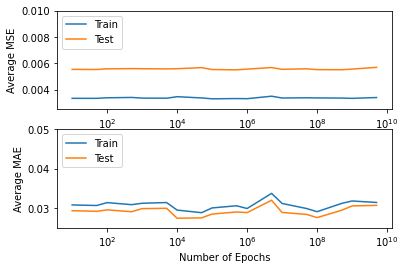

In [19]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.semilogx(epochs, epoch_metrics.where(epoch_metrics.Set == "Train").dropna().MSE, label='Train')
plt.semilogx(epochs, epoch_metrics.where(epoch_metrics.Set == "Test").dropna().MSE, label='Test')

plt.legend(loc='upper left')
plt.ylim([0.0025, 0.01])
plt.xlabel('Number of Epochs')
plt.ylabel('Average MSE')

# Show estimated coef_ vs true coef

plt.subplot(2, 1, 2)
plt.semilogx(epochs, epoch_metrics.where(epoch_metrics.Set == "Train").dropna().MAE, label='Train')
plt.semilogx(epochs, epoch_metrics.where(epoch_metrics.Set == "Test").dropna().MAE, label='Test')

plt.legend(loc='upper left')
plt.ylim([0.025, 0.05])
plt.xlabel('Number of Epochs')
plt.ylabel('Average MAE')
plt.show()


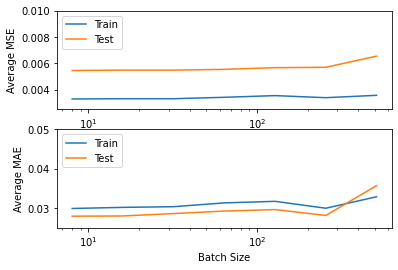

In [20]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.semilogx(batches, batch_metrics.where(batch_metrics.Set == "Train").dropna().MSE, label='Train')
plt.semilogx(batches, batch_metrics.where(batch_metrics.Set == "Test").dropna().MSE, label='Test')

plt.legend(loc='upper left')
plt.ylim([0.0025, 0.01])
plt.xlabel('Batch Size')
plt.ylabel('Average MSE')

# Show estimated coef_ vs true coef

plt.subplot(2, 1, 2)
plt.semilogx(batches, batch_metrics.where(batch_metrics.Set == "Train").dropna().MAE, label='Train')
plt.semilogx(batches, batch_metrics.where(batch_metrics.Set == "Test").dropna().MAE, label='Test')

plt.legend(loc='upper left')
plt.ylim([0.025, 0.05])
plt.xlabel('Batch Size')
plt.ylabel('Average MAE')
plt.show()